In [1]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import EstimatorPreprocessor as ep
from datetime import datetime
import math
from numpy import concatenate

In [2]:
data = ep.load_cleaned_submissions()

In [3]:
df = pd.DataFrame()

In [4]:
df["Date"] = pd.to_datetime(data.created_utc.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')))
df["Sentiment"] = data.sentiment
df["Scores"] = df.Sentiment.apply(lambda x: 1 if x == "bullish" else (-1 if x == "bearish" else 0))

In [5]:
df = df.groupby("Date", as_index = False)["Scores"].sum("Sum")

In [6]:
df["LogScores"] = df.Scores.apply(lambda x: math.log(x) if x > 0 else 0)

In [7]:
# Start Time Series Analysis

In [8]:
ts = pd.read_excel("data/stock_prices.xlsx", usecols = ["Date", "Adj Close", "Volume"])
ts["Close_Diff"] = ts["Adj Close"].diff()

In [9]:
# Add sentiment to stock price time series data
ts = pd.merge(ts, df, how = "left", on = "Date").fillna(0)
ts

,Date,Adj Close,Volume,Close_Diff,Scores,LogScores
0,2019-12-31,6.080000,4322600,0.000000,0.0,0.000000
1,2020-01-02,6.310000,4453600,0.230000,0.0,0.000000
2,2020-01-03,5.880000,3543900,-0.430000,0.0,0.000000
3,2020-01-06,5.850000,3394800,-0.030000,1.0,0.000000
4,2020-01-07,5.520000,5228000,-0.330000,0.0,0.000000
...,...,...,...,...,...,...
454,2021-10-19,186.789993,2070600,0.769989,28.0,3.332205
455,2021-10-20,184.520004,2276900,-2.269989,9.0,2.197225
456,2021-10-21,181.710007,2402400,-2.809998,19.0,2.944439
457,2021-10-22,169.800003,2800400,-11.910004,25.0,3.218876


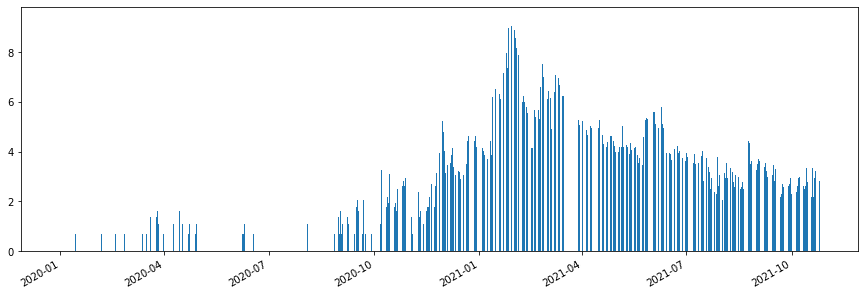

In [10]:
# Add stock prices and volume a bit later
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(ts.Date, ts.LogScores)
ax.tick_params(axis="x", labelbottom=True, rotation=45)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.show()

In [11]:
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [12]:
ts

,Date,Adj Close,Volume,Close_Diff,Scores,LogScores
0,2019-12-31,6.080000,4322600,0.000000,0.0,0.000000
1,2020-01-02,6.310000,4453600,0.230000,0.0,0.000000
2,2020-01-03,5.880000,3543900,-0.430000,0.0,0.000000
3,2020-01-06,5.850000,3394800,-0.030000,1.0,0.000000
4,2020-01-07,5.520000,5228000,-0.330000,0.0,0.000000
...,...,...,...,...,...,...
454,2021-10-19,186.789993,2070600,0.769989,28.0,3.332205
455,2021-10-20,184.520004,2276900,-2.269989,9.0,2.197225
456,2021-10-21,181.710007,2402400,-2.809998,19.0,2.944439
457,2021-10-22,169.800003,2800400,-11.910004,25.0,3.218876


In [13]:
ts.columns

Index(['Date', 'Adj Close', 'Volume', 'Close_Diff', 'Scores', 'LogScores'], dtype='object')

In [14]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ts.loc[:, ["Adj Close", "Volume"]])

In [15]:
np.round(training_set_scaled[:10, :], 2)

array([[0.01, 0.02],
       [0.01, 0.02],
       [0.01, 0.01],
       [0.01, 0.01],
       [0.01, 0.02],
       [0.01, 0.02],
       [0.01, 0.01],
       [0.01, 0.01],
       [0.01, 0.01],
       [0.01, 0.06]])

In [16]:
# Train, test split
series = training_set_scaled
train_size = int(round(len(series) * 0.80, 0))

train_set = series[:train_size]
test_set = series[train_size:]

In [17]:
assert (len(train_set) + len(test_set)) == len(series)

In [18]:
def create_dataset(dataset, look_back = 1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [19]:
LOOK_BACK = 1
X_train, y_train = create_dataset(train_set, LOOK_BACK)
X_test, y_test = create_dataset(test_set, LOOK_BACK)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((365, 1, 2), (365,), (90, 1, 2), (90,))

In [21]:
# The LSTM network expects the input data (X) to be provided in the form of: [samples, time steps, features].
# Currently, our data is in the form: [samples, time steps]
def reshape_data(X_train, X_test):
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    return X_train, X_test

X_train, X_test = reshape_data(X_train, X_test)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((365, 1, 2), (365,), (90, 1, 2), (90,))

In [30]:
def build_model(opt, d, l):
    model = Sequential()
    model.add(LSTM(4, input_shape = (l, X_train.shape[2]), dropout = d)) # , return_sequences = True
    # model.add(LSTM(4, input_shape = (1, LOOK_BACK))) # If more layers are included, the comment from above also needs to be included.
    model.add(Dense(1))
    model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = 'RootMeanSquaredError')
    return model

In [31]:
param_list = []

opti = ["rmsprop", "SGD", "Adam"]
drop = [0, 0.1, 0.2]
l_back = [1, 2, 3, 4, 5]

for l in l_back:
    X_train, y_train = create_dataset(train_set, l)
    X_test, y_test = create_dataset(test_set, l)
    X_train, X_test = reshape_data(X_train, X_test)
    for opt in opti:
        for d in drop:
            model = build_model(opt, d, l)
            history = model.fit(X_train, y_train, epochs = 100, batch_size = 1, validation_split = 0.2, verbose = 0)
            param_list.append("Dropout: " + str(d) + 
                                    " & Optimizer:" + opt +
                                    " & Lookback: " + str(l) +
                                    " ;Train MSE: " + str(history.history['root_mean_squared_error']) + 
                                    " ;Train Loss: "+ str(history.history['loss']) + 
                                    " ;Val MSE:" + str(history.history['val_root_mean_squared_error']) +
                                    " ;Val Loss:" + str(history.history['val_loss'])
                                )

2022-01-05 12:08:12.033376: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
params = []
train_rmse = []
val_rmse = []
train_loss = []
val_loss = []

for item in param_list:
    params.append(item.split(";")[0])
for item in param_list:
    train_rmse.append(item.split(";")[1][13:-2].split(", "))
for item in param_list:
    train_loss.append(item.split(";")[2][13:-2].split(", "))
for item in param_list:
    val_rmse.append(item.split(";")[3][10:-2].split(", "))
for item in param_list:
    val_loss.append(item.split(";")[4][10:-1].split(", "))

e = list(np.arange(1, len(val_rmse[0])+1, 1))

In [33]:
from itertools import chain

df = pd.DataFrame({
    "Epoch": [item for item in e*len(val_loss)],
    "Params": [item for item in sorted(params * len(e))],
    "Train_RMSE": [item for item in sc.inverse_transform(np.array(list(chain.from_iterable(train_rmse))).reshape(-1, 1))],
    "Train_Loss": [item for item in sc.inverse_transform(np.array(list(chain.from_iterable(train_loss))).reshape(-1, 1))],
    "Val_RMSE": [item for item in sc.inverse_transform(np.array(list(chain.from_iterable(val_rmse))).reshape(-1, 1))],
    "Val_Loss": [item for item in sc.inverse_transform(np.array(list(chain.from_iterable(val_loss))).reshape(-1, 1))]
    }
)

In [34]:
df.to_csv("./eval_model/lstm_with_only_trading_volume.csv", sep='\t')

In [35]:
X_train.shape

(361, 5, 2)

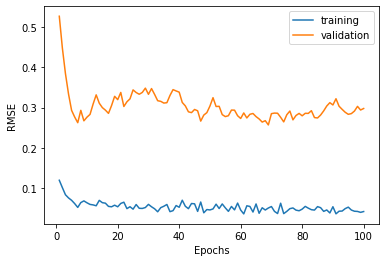

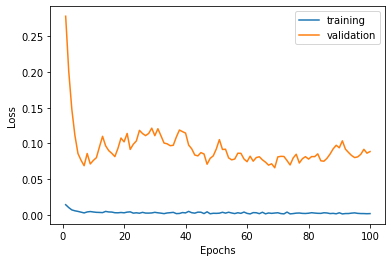

In [36]:
import matplotlib.pyplot as plt

rmse_history = history.history["root_mean_squared_error"]
val_rmse_history = history.history["val_root_mean_squared_error"]

plt.plot(range(1, len(rmse_history) + 1), rmse_history)
plt.plot(range(1, len(val_rmse_history) + 1), val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

# Best Model

In [23]:
def build_model(opt, d, l):
    model = Sequential()
    model.add(LSTM(4, input_shape = (l, X_train.shape[2]), dropout = d)) # , return_sequences = True
    # model.add(LSTM(4, input_shape = (1, LOOK_BACK))) # If more layers are included, the comment from above also needs to be included.
    model.add(Dense(1))
    model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = 'RootMeanSquaredError')
    return model

In [24]:
param_list = []

opti = ["Adam"]
drop = [0]
l_back = [1]

for l in l_back:
    X_train, y_train = create_dataset(train_set, l)
    X_test, y_test = create_dataset(test_set, l)
    X_train, X_test = reshape_data(X_train, X_test)
    for opt in opti:
        for d in drop:
            model = build_model(opt, d, l)
            history = model.fit(X_train, y_train, epochs = 72, batch_size = 1, verbose = 0)
            param_list.append("Dropout: " + str(d) + 
                                    " & Optimizer:" + opt +
                                    " & Lookback: " + str(l) +
                                    " ;Train MSE: " + str(history.history['root_mean_squared_error']) + 
                                    " ;Train Loss: "+ str(history.history['loss'])
                                )

2022-01-05 15:06:55.473640: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
y_pred = model.predict(X_test)
y_pred = concatenate((y_pred, X_test[:, 0, 1:]), axis = 1)
y_pred = sc.inverse_transform(y_pred)[:, 0]

In [26]:
y_test = y_test.reshape(-1, 1)
y_test = concatenate((y_test, X_test[:, 0, 1:]), axis = 1)
y_test = sc.inverse_transform(y_test)[:, 0]

In [27]:
trainPredict = model.predict(X_train)
trainPredict.shape

(365, 1)

In [28]:
trainPredict = concatenate((trainPredict, X_train[:, 0, 1:]), axis = 1)

trainPredict = model.predict(X_train)
trainPredict = concatenate((trainPredict, X_train[:, 0, 1:]), axis = 1)
trainPredict = sc.inverse_transform(trainPredict)[:, 0]

In [29]:
testPredict = y_pred

In [30]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

testscore_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
testscore_mse = mean_squared_error(y_test, y_pred)
testscore_mae = mean_absolute_error(y_test, y_pred)

print("RMSE: ", testscore_rmse, "MSE: ", testscore_mse, "MAE: ", testscore_mae)

RMSE:  7.937265374050835 MSE:  63.00018161810634 MAE:  5.538415269538018


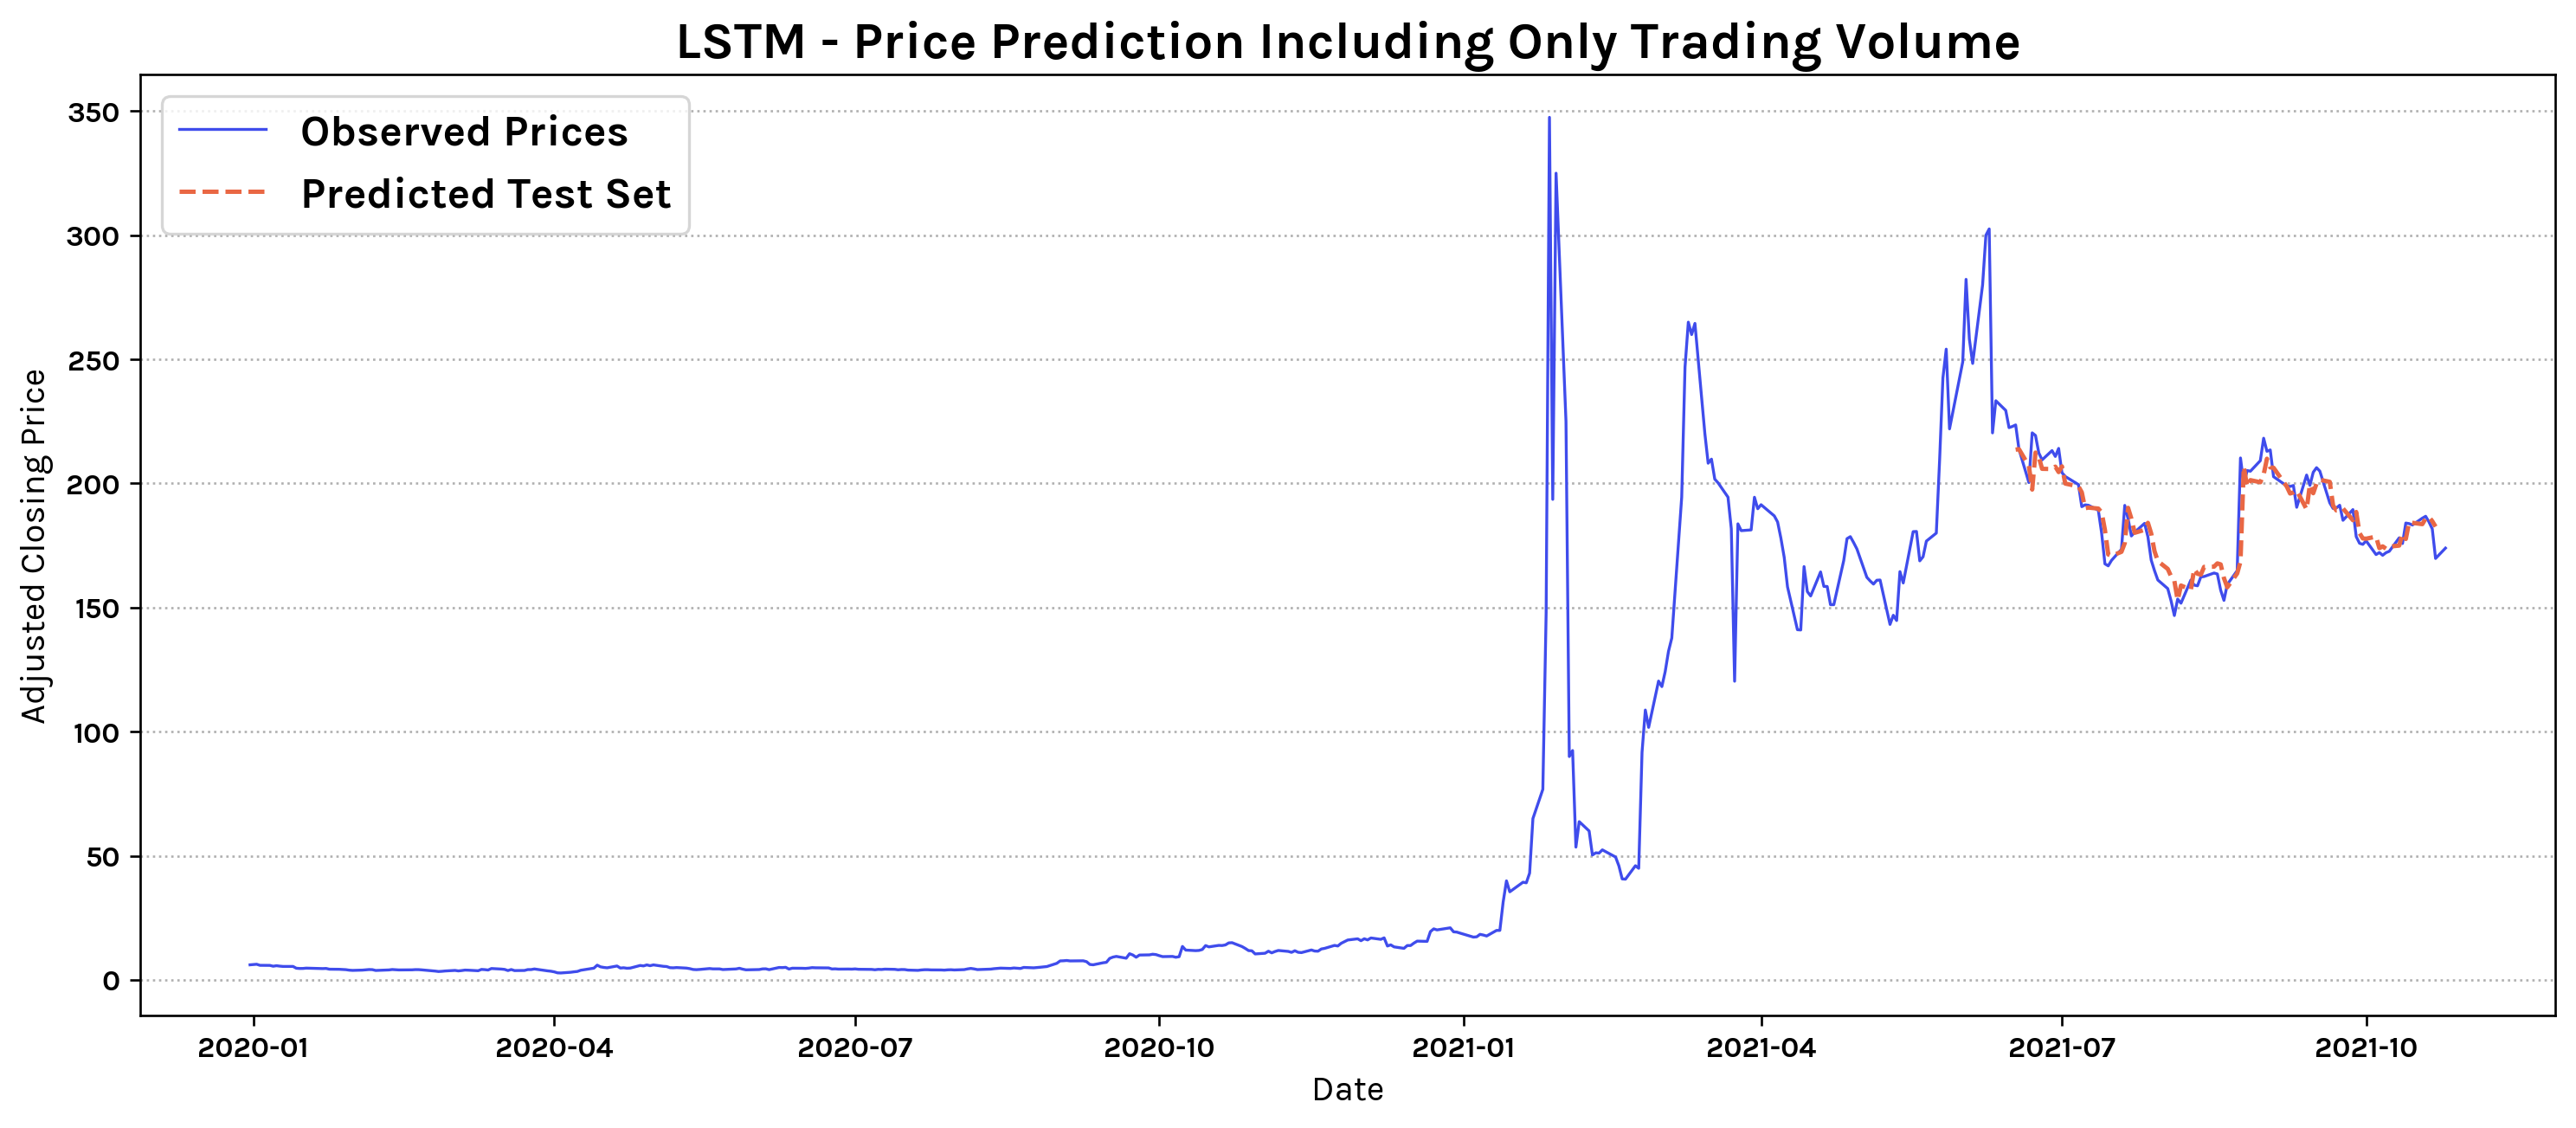

In [31]:
plt.rcParams['font.sans-serif'] = "Karla"
plt.rcParams["font.weight"] = "bold"

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=240)

trainPredictPlot = np.empty_like(training_set_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot = trainPredictPlot[:, 0]
trainPredictPlot[l:len(trainPredict)+l] = trainPredict

testPredictPlot = np.empty_like(training_set_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot = testPredictPlot[:, 0]
testPredictPlot[len(trainPredict)+(l*2)+1:len(training_set_scaled)-1] = testPredict

x = ts.Date

plt.plot(x, sc.inverse_transform(training_set_scaled)[:, 0], color = "#3F4CEC", linewidth = 1, label = "Observed Prices")
# plt.plot(x, trainPredictPlot, color = "#FFC322", linestyle='dashed', label = "Predicted Train Set")
plt.plot(x, testPredictPlot, color = "#E96744", linestyle='dashed', label = "Predicted Test Set")
plt.legend(loc="upper left", prop={'size': 15})
plt.ylabel("Adjusted Closing Price", fontsize = 12)
plt.grid(axis = "y", linestyle = "dotted")
plt.xlabel("Date", fontsize = 12)
plt.title("LSTM - Price Prediction Including Only Trading Volume", fontsize = 18, weight = "bold")

plt.show()